<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2023/blob/main/notebooks/es11/MetodiAI_Fis2023_Es11_VAE_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelli generativi basati su VAE e GAN

scopo: familiarizzare con la progettazione e l'uso di archietture generative basate su VAE e GAN 

DL tool: pytorch

### tasks ###

1.   implementazione di una beta-VAE (eg una VAE con un iperparametro che controlla il peso relativo del termine di divergenza rispetto al termine di ricostruzione nella loss per la generazione di immagini realistiche
2.   implementazione di una Deep Convolutional GAN (DCGAN) addestrata per generare immagini realistiche 

Referenze:

*   [VAE](https://arxiv.org/abs/1312.6114) e [beta-VAE](https://openreview.net/forum?id=Sy2fzU9gl)
*   [DCGAN](https://arxiv.org/pdf/1511.06434.pdf)


**Datasets:**

*  [fashion-MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST)



In [ ]:
# import delle librerie
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

from torch import nn
import torch.nn.functional as F

2.0.1+cu118
0.15.2+cu118


il dataset FashionMNIST è costituito da immagini di icone di oggetti di viestiario corrispondenti a 60k immagini per il training e 10k immagini per il test.

Ogni immagine ha dimensione $(28,28)$ pixel, con un canale di intensità (scala di grigi) a 8 bit (valori di intensità di ogni pixel $\in [0,256]$).

È disponibile in varie librerie per il ML (scikit-learn, torch, tensorflow, librerie esterne...). Prendendo il dataset già disponibile in pytorch possiamo sfruttare il vantaggio di di avere conversioni automatiche in tensori torch e normalizzazioni. Leggendo il dataset da un input esterno, come per esempio fatto nell'esercitazione su PCA prendendolo da openm, in formato di ndarray numpy, dovremo convertire noi i vettori in tensori torch e normalizzarli, ma risulterà più chiaro come usare in generale datset esterni. in questo hands-on utilizzeremo questo secondo approccio.

In [ ]:
# lettura del dataset Fashion-MNIST da openml usando la libreria sklearn
# label:
# 0 T-shirt/top
# 1 Trouser
# 2 Pullover
# 3 Dress
# 4 Coat
# 5 Sandal
# 6 Shirt
# 7 Sneaker
# 8 Bag
# 9 Ankle boot

from sklearn.datasets import fetch_openml

images, labels = fetch_openml("Fashion-MNIST", version=1, return_X_y=True, as_frame=False, parser="pandas")
labels = labels.astype(int) # converte le label in int

print(images.shape)
print(labels.shape)

(70000, 784)
(70000,)


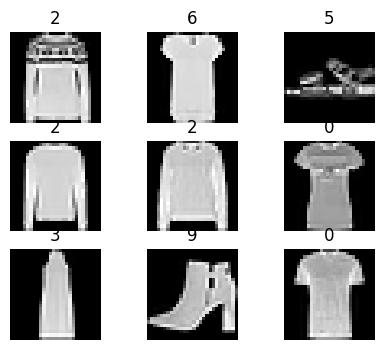

In [ ]:
# grafichiamo 9 immagini random
figure = plt.figure(figsize=(5, 4))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(images))
    img, label = images[sample_idx], labels[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.reshape((28,28)), cmap="gray")
plt.show()

In [ ]:
# splitting del campione in training e test (80:20)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=12345)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(56000, 784)
(56000,)
(14000, 784)
(14000,)


In [ ]:
# le immagini Fashion-MNIST sono immagini in scala di grigio a 8 bit, ogni pixel assume valore [0,255], quindi per
# normalizzare in [0,1] basta solo divider tutte le immagini per 255

X_train_norm = X_train / 255.
X_test_norm  = X_test / 255.

In [ ]:
# per questa esercitazione è consigliabile usare una GPU
# controlliamo se la GPU è disponibile e nel caso quale tipo di GPU
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili:  1
Tesla T4
Computation device: cuda



In [ ]:
# conversione in tensori torch dei vettori numpy

X_train_pt = torch.Tensor(X_train_norm).float()
Y_train_pt = torch.Tensor(Y_train).int()
X_test_pt = torch.Tensor(X_test_norm).float()
Y_test_pt = torch.Tensor(Y_test).int()

# reshape the tensori da (n,784) a (n,1,28,28) come richiesto da conv layer in pytorch

X_train_pt = X_train_pt.view((X_train_pt.shape[0],1,28,28))
X_test_pt = X_test_pt.view((X_test_pt.shape[0],1,28,28))

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

torch.Size([56000, 1, 28, 28])
torch.Size([56000])
torch.Size([14000, 1, 28, 28])
torch.Size([14000])


In [ ]:
# dataset e dataloaders

batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt) 
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True) 

dataset_test = TensorDataset(X_test_pt, Y_test_pt) 
test_dl = DataLoader(dataset_test, batch_size=1, shuffle=True, num_workers=1, drop_last=True)

### Definzione del modello di rete neurale.

Architettura: VAE convoluzionale con encoder costituito da 2 layer convoluzionali 2D con kernel_size 4 e stride 2 (per comprimere le rappresentazioni), decoder costituito da ConvTranspose2D. Lo spazio latente z è costituito da un layer denso. Usiamo attivazioni ReLu nella parte convoluzionale e sigmoide nell'output in modo da allenare il modello con BCE come reconstruction loss + KL-divergence come regolarizzatore 

In [ ]:
# Convolutional Encoder Model

class Encoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=hidden_channels, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=hidden_channels, 
                               out_channels=hidden_channels*2, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1) # output: hidden_channels x 2 x 7 x 7

        self.fc_mu = nn.Linear(in_features=hidden_channels*2*7*7, 
                               out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=hidden_channels*2*7*7, 
                                   out_features=latent_dim)
            
        self.activation = nn.ReLU()

    def forward(self, x):
    
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))

        x = x.view(x.shape[0], -1) #flatten

        # predizione dell'encoder: mu and logvariance
        # più stabile rispetto a predire mu e sigma: https://stats.stackexchange.com/a/353222/284141 
       
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)

        return x_mu, x_logvar

In [ ]:
# Convolutional Decoder Model

class Decoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()
        self.hidden_channels = hidden_channels

        self.fc = nn.Linear(in_features=latent_dim, 
                            out_features=hidden_channels*2*7*7)

        self.conv2 = nn.ConvTranspose2d(in_channels=hidden_channels*2, 
                                        out_channels=hidden_channels, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=hidden_channels, 
                                        out_channels=1, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=1)
        
        self.activation = nn.ReLU()
        
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), self.hidden_channels*2, 7, 7)
        x = self.activation(self.conv2(x))
        out = torch.sigmoid(self.conv1(x)) # final activation sigmoid (works with BCELoss as reconstruction loss)
        return out

In [ ]:
# Full VAE/AE Model

use_VAE = True #False: AE, True: VAE

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)

        #VAE/AE
        
        # .. da SCRIVERE

        # ritorna x ricostruito, mu, e logvar
        return x_recon, latent_mu, latent_logvar
    
    # sampling function (implementa il reparametrization trick)
    def latent_sample(self, mu, logvar):
        if self.training: #true se si è in training mode
            
            # .. da SCRIVERE 
            
        else:
            return mu

In [ ]:
# Istanziamo il modello

hidden_channels = 64
latent_dim = 2 #dimensione dello spazio latente z

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_vae = VAE(encoder, decoder)

print(model_vae)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model_vae.cuda(), input_size=(1,28,28))
else:
  summary(model_vae, input_size=(1,28,28))

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=6272, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=6272, out_features=2, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (fc): Linear(in_features=2, out_features=6272, bias=True)
    (conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (activation): ReLU()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,088
              ReLU-2           [-1, 64, 14, 14]               0
            Conv2d-3            [-1, 128, 7, 7]         131,200
              ReLU-4            [-1, 128

In [ ]:
# testiamo il modello su un batch

model_vae.to(device)

model_vae.eval()

x,_ = next(iter(train_dl))

x=x.to(device)

xtilde,mu,logv = model_vae(x)

print(mu.shape)
print(xtilde.shape)

torch.Size([128, 2])
torch.Size([128, 1, 28, 28])


In [ ]:
# definizione della loss
# custom loss che include il termine di recostruzione BCELoss + la KL-Divergence per prior gaussiani
# in pratica una VAE è un AE con regolarizazione (data dalla KL loss) che evita che l'AE overiftti i dati e che lo spazio latente 
# abbia una struttura adeguata per essere campionato per generare nuovi esempi

# implementiamo una betaVAE (una VAE in cui il peso relativo tra reco-loss e kl-loss è controllato da un iperparametro beta)
# beta loss (loss = reco + beta*kl-divergence)

beta_par = 1.0

# VAE loss
def vae_loss(recon_x, x, mu, logvar):

  recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

  if use_VAE:
    # closed form of KL divergence for normal priors: (-1/2 sum (1 + log sigma^2 - mu^2 - sigma^2))
    # sta assumendo che p(z) sia fatta da distribuzioni normali standardizzate (N(0,1))
    
    kldivergence = # .. da SCRIVERE
  else:
    kldivergence = 0.0

  return recon_loss + beta_par * kldivergence, recon_loss, beta_par * kldivergence

In [ ]:
# Training


# Istanziamo un nuovo modello

hidden_channels = 64
latent_dim = 2 #dimensione dello spazio latente z

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_vae = VAE(encoder, decoder)

model_vae = model_vae.to(device)


# Optimizer    
LR = 1.e-3
opt = torch.optim.Adam(params=model_vae.parameters(), lr=LR, weight_decay=1e-5)

In [ ]:
# Training loop ... basta solo il loop sul training per fare prima ...

import time

epochs = 60
hist_loss = []
hist_kloss = []
hist_rloss = []

for epoch in range(epochs):
    t0 = time.time()
    
    # training step
    model_vae.train()
    train_loss = 0.
    train_rloss = 0.
    train_kloss = 0.
    counter = 0

    for xb, _ in train_dl:
        counter += 1
        xb=xb.to(device)  

        # .. da SCRIVERE

        train_loss += loss.item()
        train_rloss += rloss.item()
        train_kloss += kloss.item()

        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()


    train_loss /= counter
    train_rloss /= counter
    train_kloss /= counter

    hist_loss.append(train_loss)
    hist_rloss.append(train_rloss)
    hist_kloss.append(train_kloss)


    # aggiungere la parte su validation usando il test set

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train reco loss: %.6f, train kl loss: %.6f"
          % (epoch+1, elapsed_time, train_loss, train_rloss, train_kloss))

epoch: 1, time(s): 3.7514, train loss: 37466.906509, train reco loss: 36647.310641, train kl loss: 819.595843
epoch: 2, time(s): 3.6080, train loss: 34758.858803, train reco loss: 34005.910938, train kl loss: 752.947881
epoch: 3, time(s): 3.9784, train loss: 34413.375742, train reco loss: 33659.426635, train kl loss: 753.948970
epoch: 4, time(s): 3.7468, train loss: 34224.198937, train reco loss: 33465.617965, train kl loss: 758.580939
epoch: 5, time(s): 3.8214, train loss: 34098.982185, train reco loss: 33333.779824, train kl loss: 765.202391
epoch: 6, time(s): 3.9299, train loss: 33987.331146, train reco loss: 33218.189337, train kl loss: 769.141754
epoch: 7, time(s): 3.6076, train loss: 33906.493801, train reco loss: 33131.666387, train kl loss: 774.827337
epoch: 8, time(s): 3.5788, train loss: 33827.430166, train reco loss: 33048.336456, train kl loss: 779.093651
epoch: 9, time(s): 3.7385, train loss: 33780.586764, train reco loss: 32998.874687, train kl loss: 781.712062
epoch: 10,

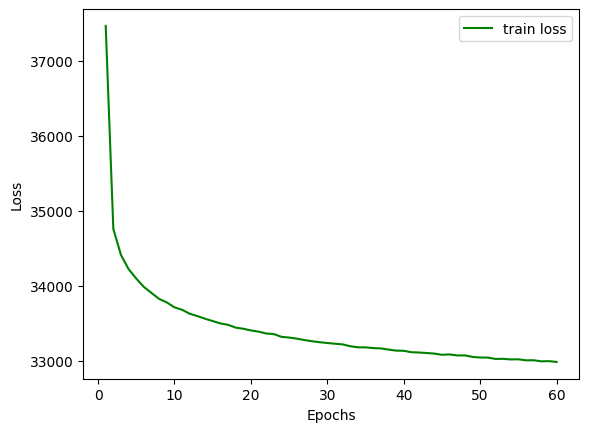

In [ ]:
# training loss plot (aggiungere la parte sul test set)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
#plt.plot(range(1,len(hist_rloss)+1), hist_rloss, color='red', linestyle='-', label='train rloss')
#plt.plot(range(1,len(hist_kloss)+1), hist_kloss, color='blue', linestyle='-', label='train kloss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

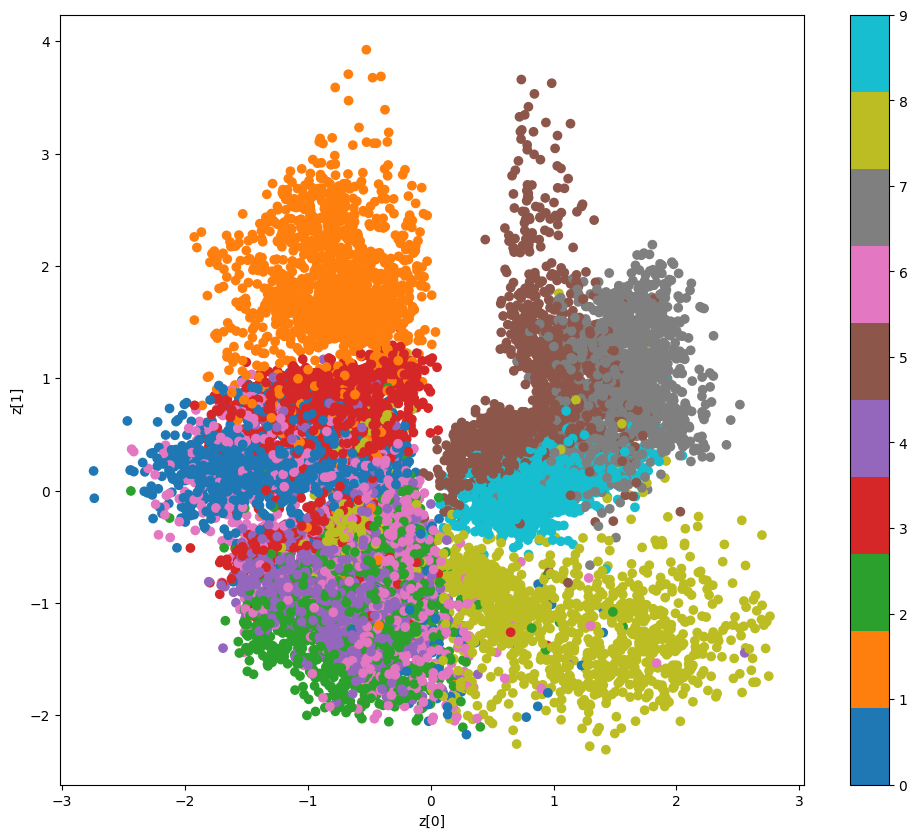

In [ ]:
# Plot dello spazio latente appreso (z1 vs z2)

model_vae.eval()

z = np.empty(shape=(len(test_dl),2))
y = np.empty(shape=(len(test_dl)))
counter = 0
with torch.no_grad(): 
  for idx, (xb, yb) in enumerate(test_dl):
    xb=xb.to(device)  
    zl,_ = encoder(xb)
    z[idx,0] = zl[0,0].item()
    z[idx,1] = zl[0,1].item()
    y[idx] = yb.item()

plt.figure(figsize=(12, 10))
plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

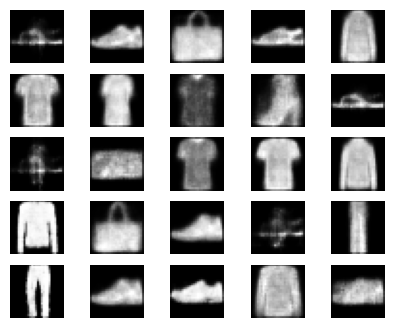

In [ ]:
# Uso come generatore

# 1) si estraggono numeri random z in accordo to p(z) = N(0,1) (eg il prior utilizzato nella KL-D)
# 2) si calcolano x = decoder(z)

n = 5
numero_esempi = n**2

# .. da SCRIVERE


figure = plt.figure(figsize=(5, 4))
cols, rows = n, n 
for i in range(numero_esempi): 
    img = x_sample[i].detach().numpy()
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(img.reshape((28,28)), cmap="gray")
plt.show()



### DCGAN GAN on fashion MNIST

In [ ]:
# DCGAN model from pytorch web site (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)


# Spatial size of training images.
image_size = 28

# Number of channels in the training images 1: scala di grigio, 3: immagini a colori RGB
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [ ]:
# custom weights initialization per il generatore e discriminatore
# dall'articolo oroginale DGGAN "all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02"
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.main = nn.Sequential(
          # input is Z, going into transpose convolutions
          nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(ngf * 4),
          nn.ReLU(True),
          # state size. (ngf*4) x 4 x 4
          nn.ConvTranspose2d(ngf * 4, ngf * 2, 2, 2, 0, bias=False),
          nn.BatchNorm2d(ngf * 2),
          nn.ReLU(True),
          # state size. (ngf*4) x 8 x 8
          nn.ConvTranspose2d( ngf * 2, ngf, 2, 2, 0, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
          # state size. (ngf) x 16 x 16
          nn.ConvTranspose2d( ngf, nc, 2, 2, 2, bias=False),
          nn.Tanh()
          # state size. (nc) x 28 x 28
      )

    def forward(self, input):
      return self.main(input)


In [ ]:
# Creiamo il generatore
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

from torchsummary import summary
if torch.cuda.is_available():
  summary(netG.cuda(), input_size=(100,1,1))
else:
  summary(netG.cuda(), input_size=(100,1,1))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2), bias=False)
    (10): Tanh()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 128, 4, 4]         204,800
       BatchNorm2d-2            [-1, 128, 4, 4]             2

In [ ]:
# testiamo il generatore

z = torch.randn(1, nz, 1, 1) # generiamo 1 vettore latente z random
z = z.cpu()

netG=netG.cpu()
out = netG(z)

print(out.shape)

torch.Size([1, 1, 28, 28])


In [ ]:
# discriminator (un classificatore che classifica immagini FashionMNIST vere da fake)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 2, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(ndf, ndf * 2, 2, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [ ]:
# Creiamo il Discriminatore
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

from torchsummary import summary
if torch.cuda.is_available():
  summary(netD.cuda(), input_size=(1,28,28))
else:
  summary(netD.cuda(), input_size=(1,28,28))

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 15, 15]             128
         LeakyReLU-2           [-1, 32, 15, 15]               0
           

In [ ]:
# testiamo il discriminatore

img = torch.randn(1, 1, 28, 28)
img = img.cpu()

netD=netD.cpu()
out = netD(img)

print(out.shape)

torch.Size([1, 1, 1, 1])


In [ ]:
# Loss e ottimizzatori

# BCELoss function
criterion = nn.BCELoss()

# crea un batch di 64 vettori latenti z ognuno di dimensione nz da usare per monitorare le immagini 
# generate dal generatore durante il training a epoche diverse

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# definiamo la convenzione per le label reali e fake durante il training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D (servono due ottmizzatori separati)
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop (dove l'adversarial training viene implementato)

import torchvision.utils as vutils

netG=netG.to(device)
netD=netD.to(device)

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dl, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_data).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label) # riempie un tensore esistente con il valore dato
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_dl),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dl)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/437]	Loss_D: 0.8966	Loss_G: 1.2915	D(x): 0.7104	D(G(z)): 0.4026 / 0.2921
[0/5][50/437]	Loss_D: 0.1126	Loss_G: 3.6557	D(x): 0.9571	D(G(z)): 0.0633 / 0.0328
[0/5][100/437]	Loss_D: 0.2785	Loss_G: 2.8095	D(x): 0.9508	D(G(z)): 0.1981 / 0.0674
[0/5][150/437]	Loss_D: 0.1841	Loss_G: 2.6803	D(x): 0.9196	D(G(z)): 0.0894 / 0.0812
[0/5][200/437]	Loss_D: 0.1769	Loss_G: 2.8248	D(x): 0.9372	D(G(z)): 0.0993 / 0.0741
[0/5][250/437]	Loss_D: 0.1922	Loss_G: 2.2938	D(x): 0.8722	D(G(z)): 0.0439 / 0.1276
[0/5][300/437]	Loss_D: 0.2393	Loss_G: 1.9466	D(x): 0.9304	D(G(z)): 0.1434 / 0.1671
[0/5][350/437]	Loss_D: 0.1468	Loss_G: 3.1593	D(x): 0.9273	D(G(z)): 0.0647 / 0.0519
[0/5][400/437]	Loss_D: 0.1368	Loss_G: 3.2187	D(x): 0.9165	D(G(z)): 0.0435 / 0.0503
[1/5][0/437]	Loss_D: 0.1984	Loss_G: 3.3165	D(x): 0.9522	D(G(z)): 0.1339 / 0.0427
[1/5][50/437]	Loss_D: 0.1423	Loss_G: 3.0275	D(x): 0.9582	D(G(z)): 0.0918 / 0.0602
[1/5][100/437]	Loss_D: 0.1379	Loss_G: 2.9348	D(x): 0.9643	D(G(z)): 

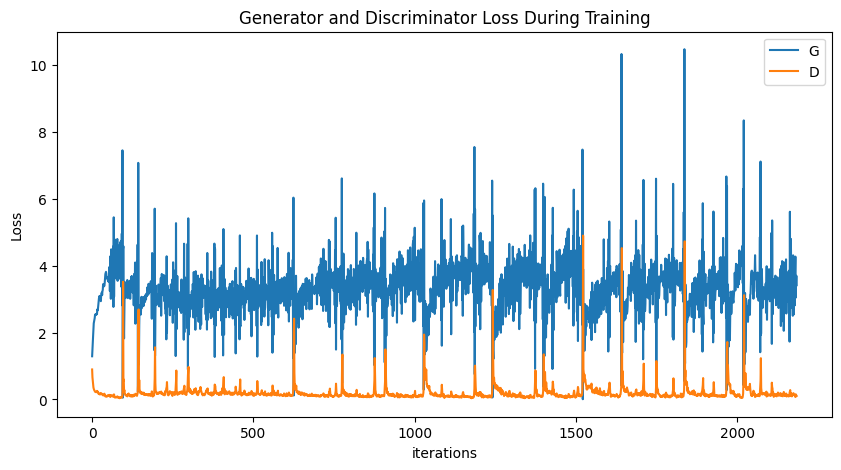

In [ ]:
# plot dei valori delle loss per D e G durante il training D
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
img_list[-1].shape

torch.Size([3, 242, 242])

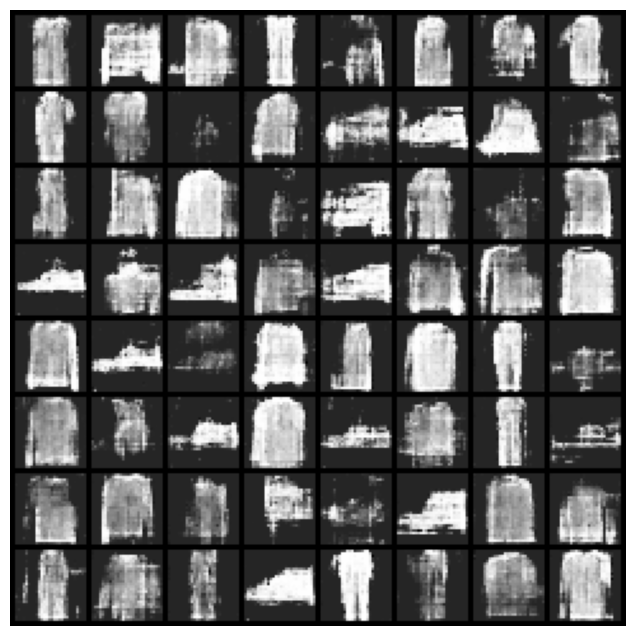

In [ ]:
# plot dell'output di G per il set fixed_batch generato all'inizio

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

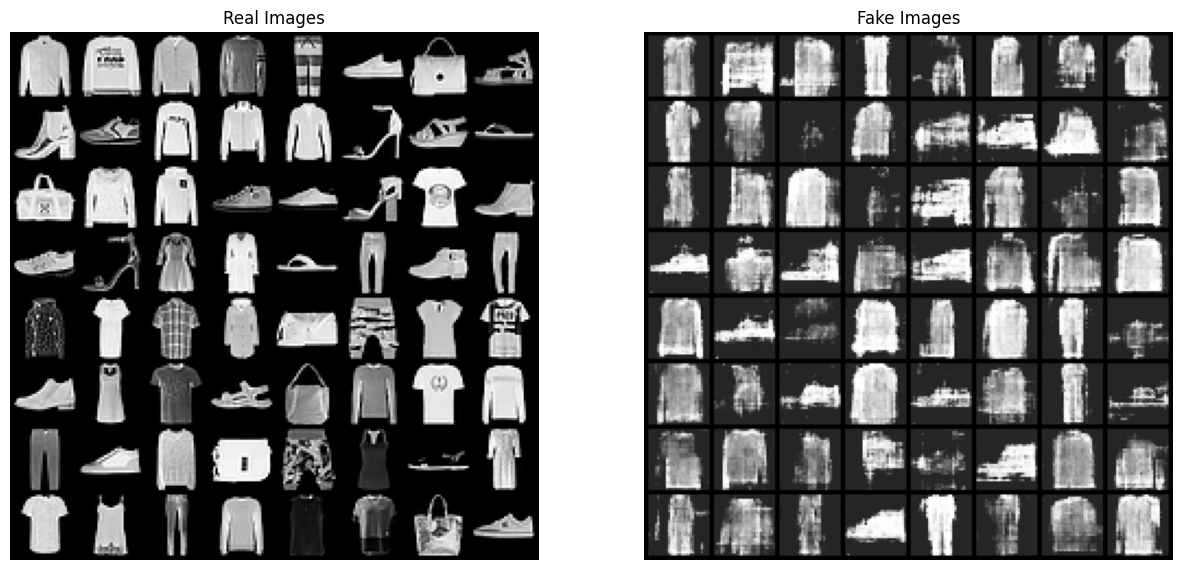

In [ ]:
# plot 64 immagini reali vs 64 immagini generate da G

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dl))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

**Compiti per casa**



*   giocate con la VAE, cambiando il parametro beta (ex. 0.1, 1, 10., 100.) e guardate come cambia la struttura dello spazio latente, e la qualità e variabilità degli eventi generati 
*   cercate di capire tutti gli step e le azioni eseguite dalla DCGAN, provate ad allenarla a ripordurre per esempio le immagini a colori del dataset delle foto delle mani che abbiamo utilizzato nell'esercitazione con la CNN
*   pemsare a quali potrebbero essere possibili criteri/misure per decidere quando fermare l'allenamento dell GAN

